In [ ]:
# !pip install --upgrade tensorflow
# !pip install tqdm

In [ ]:
# !pip install "tensorflow>=2.0.0"
# !pip install --upgrade tensorflow-hub

In [153]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input, Rescaling, Resizing
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, History
import time
from tqdm import tqdm
import tensorflow_hub as hub
from sklearn.metrics import confusion_matrix, roc_curve,classification_report
import seaborn as sns

In [2]:
for i in tqdm (range (100), desc="Loading..."):
  pass

Loading...: 100%|██████████| 100/100 [00:00<00:00, 957603.65it/s]


In [3]:
path_to_drive = "/content/drive/MyDrive/Colab Notebooks/malaria/"

In [4]:
malaria_dataset,info = tfds.load('malaria',as_supervised=True, split='train', with_info=True, shuffle_files=True)
malaria_dataset,info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete34RBL3/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 tfds.core.DatasetInfo(
     name='malaria',
     full_name='malaria/1.0.0',
     description="""
     The Malaria dataset contains a total of 27,558 cell images with equal instances
     of parasitized and uninfected cells from the thin blood smear slide images of
     segmented cells.
     """,
     homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
     data_path=PosixGPath('/tmp/tmp37vxkt6vtfds'),
     file_format=tfrecord,
     download_size=337.08 MiB,
     dataset_size=317.62 MiB,
     features=FeaturesDict({
         'image': Image(shape=(None, None, 3), dtype=uint8),
         'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
     }),
     supervised_keys=('image', 'label'),
     disable_shuffling=False,
     splits={
         'train': <SplitInfo num_examples=27558, num_shards=4>,
     },
     citation="""@article{raj

In [5]:
ds = malaria_dataset.take(3)

for image, label in ds:  # example is (image, label)
  print(image.shape, label)
  print(info.features['label'].int2str(label))

(103, 103, 3) tf.Tensor(1, shape=(), dtype=int64)
uninfected
(106, 121, 3) tf.Tensor(1, shape=(), dtype=int64)
uninfected
(139, 142, 3) tf.Tensor(0, shape=(), dtype=int64)
parasitized


In [6]:
int(0.8*len(malaria_dataset))/32

688.9375

In [7]:
def visualize_data(ds, k):
  # plt.figure()
  fig, axarr = plt.subplots(k, 1, figsize=(10, 2 * k), gridspec_kw={'hspace': 0.5})
  for i,(image, label) in enumerate(ds.take(k)):
    # print(image,label)
    axarr[i].set_title(info.features['label'].int2str(label))
    axarr[i].imshow(image)
  plt.axis('off')


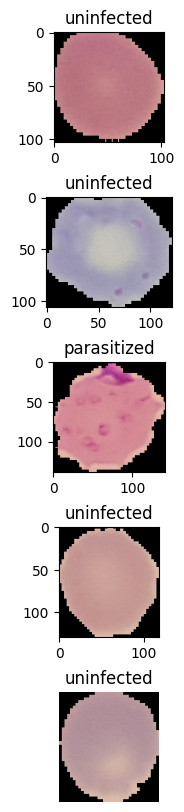

In [8]:
visualize_data(malaria_dataset,5)

# Data Preprocessing

In [9]:
def splits(dataset,TRAIN_SPLIT,VAL_SPLIT):
  dataset_size = len(dataset)

  train_ds = dataset.take(int(TRAIN_SPLIT*dataset_size))
  val_test_ds = dataset.skip(int(TRAIN_SPLIT*dataset_size))
  val_ds = val_test_ds.take(int(VAL_SPLIT*dataset_size))
  test_ds = val_test_ds.skip(int(VAL_SPLIT*dataset_size))
  return (train_ds,val_ds,test_ds)

In [10]:
train_ds,val_ds,test_ds=splits(malaria_dataset,0.8,0.1)

In [11]:
sample =list(train_ds.take(16).as_numpy_iterator())
print(np.array(sample[0][0]).shape)

(103, 103, 3)


In [12]:
IM_SIZE=224
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

## Data Augmentation

#### Using TF API

In [13]:
def resize_rescale(image,label):
  image = tf.image.resize(image,(IM_SIZE,IM_SIZE))
  image /= 255.0
  return image, label

In [14]:
def visualize_augmented_data(ds, k, layer):
    fig, axarr = plt.subplots(k, 2, figsize=(10, 2 * k), gridspec_kw={'hspace': 0.5})
    for i, (image, label) in enumerate(ds.take(k)):
      aug_img = layer(image)

      # Ensure that the data type is float32 for correct resizing
      aug_img = tf.cast(aug_img, tf.float32)

      # Resize the augmented image
      aug_img = tf.image.resize(aug_img, (IM_SIZE, IM_SIZE))

      # Convert the image back to uint8 for display
      aug_img = tf.cast(aug_img, tf.uint8)

      label_str = info.features['label'].int2str(label)
      axarr[i, 0].set_title(label_str)
      axarr[i, 0].imshow(image)
      axarr[i, 1].set_title(label_str)
      axarr[i, 1].imshow(aug_img)

    plt.axis('off')
    plt.show()



In [15]:
def random_invert_img(x, p=0.5):
  random_value = tf.random.uniform(shape=(), minval=0, maxval=1)
  if  random_value < p:
    x = (255-x)
  else:
    x
  return x

class RandomInvert(Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x, self.factor)



In [16]:
class Rot90(Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    random_value = tf.random.uniform(shape=(), minval=0, maxval=1)
    if  random_value < self.factor:
      return tf.image.rot90(x);
    else:
      return x


In [17]:
class RandomFlipUpDown(Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    random_value = tf.random.uniform(shape=(), minval=0, maxval=1)
    if  random_value < self.factor:
      return tf.image.random_flip_up_down(x);
    else:
      return x

In [18]:
class RandomFlipLeftRight(Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    random_value = tf.random.uniform(shape=(), minval=0, maxval=1)
    if  random_value < self.factor:
      return tf.image.random_flip_left_right(x);
    else:
      return x

In [19]:
class RandomCrop(Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    shape = x.shape
    new_shape = (int(shape[0]*0.8),int(shape[1]*0.8),3)
    random_value = tf.random.uniform(shape=(), minval=0, maxval=1)
    # print(new_shape)
    if  random_value < self.factor:
      return tf.image.random_crop(x, size=new_shape);
    else:
      return x

In [20]:
## can not use cropping nor inverting data augmentation techniques as it changes the image too much so it might confuse the model

class DataAugmentation(Layer):
  def __init__(self):
    super(DataAugmentation,self).__init__()
    # self.invert = RandomInvert()
    self.rot90 = Rot90()
    self.flip_up_down = RandomFlipUpDown()
    self.flip_left_right = RandomFlipLeftRight()
    # self.crop = RandomCrop()

  def call(self,x):
    # x=self.invert(x)
    x=self.rot90(x)
    x=self.flip_up_down(x)
    x=self.flip_left_right(x)
    # x=self.crop(x)
    return x

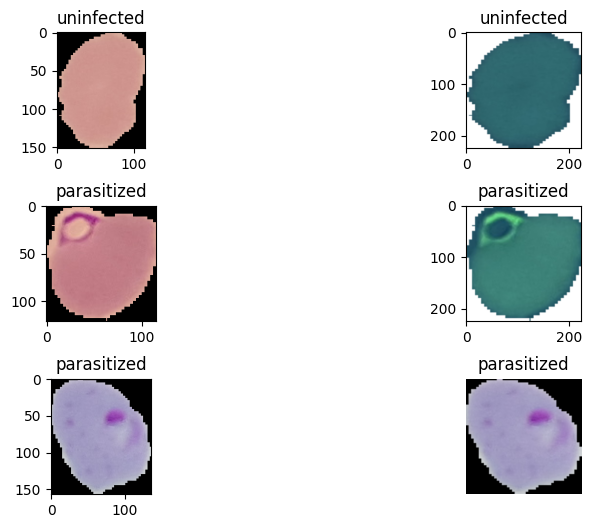

In [21]:
visualize_augmented_data(malaria_dataset,3,RandomInvert())

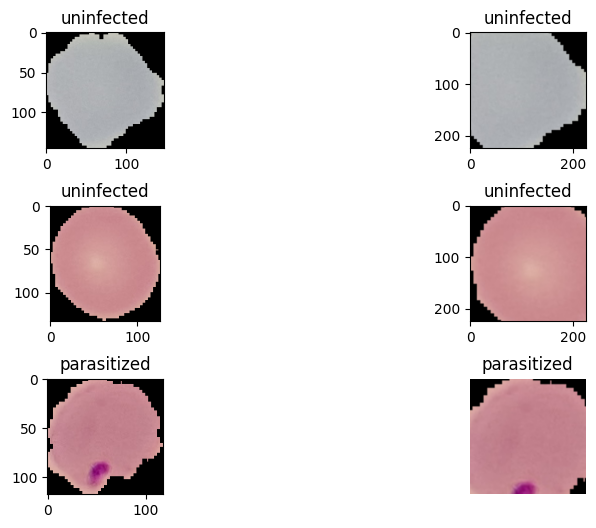

In [22]:
visualize_augmented_data(malaria_dataset,3,RandomCrop())

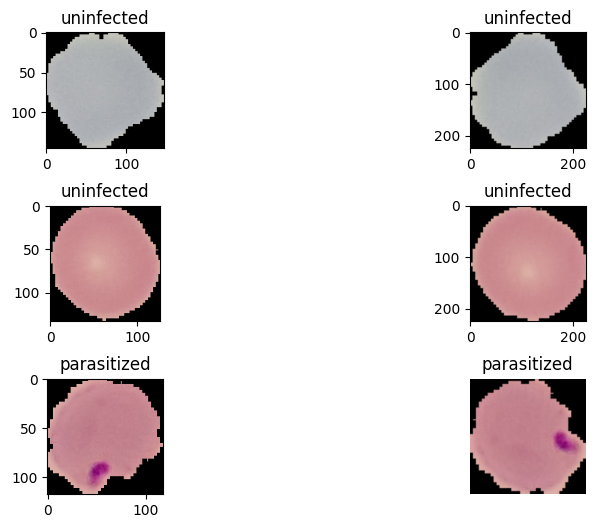

In [23]:
visualize_augmented_data(malaria_dataset,3,DataAugmentation())

In [24]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = DataAugmentation()
def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets.
  ds = ds.map(resize_rescale,
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x), y),
                num_parallel_calls=AUTOTUNE)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
# train_ds = train_ds.map(resize_rescale).shuffle(buffer_size=1000,reshuffle_each_iteration = True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.map(resize_rescale).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.map(resize_rescale).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = prepare(train_ds,shuffle=True,augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [26]:
len(train_ds)

689

# LeNet Model

In [27]:
class FeatureExtractor(Layer):
  def __init__(self,filters,pool_size,kernel_size,padding,strides,activation):
    super(FeatureExtractor,self).__init__();
    # self.resize = Resizing(IM_SIZE,IM_SIZE)
    # self.rescale = Rescaling(1/255)
    self.conv1 = Conv2D(kernel_size=kernel_size,filters=filters,strides=strides,padding=padding,activation=activation)
    self.batch1 = BatchNormalization()
    self.pool1 = MaxPool2D(pool_size=pool_size,strides=strides*2)

    self.conv2 = Conv2D(kernel_size=kernel_size,filters=filters*2,strides=strides,activation=activation)
    self.batch2 = BatchNormalization()
    self.pool2 = MaxPool2D(pool_size=pool_size,strides=strides*2)

  def call(self,x,training):
    # x= self.resize(x)
    # x= self.rescale(x)
    x= self.conv1(x)
    x= self.batch1(x)
    x= self.pool1(x)
    x= self.conv2(x)
    x= self.batch2(x)
    x= self.pool2(x)
    return x


class LeNetModel(Model):
  def __init__(self):
    super(LeNetModel,self).__init__();
    # self.data_augmentation = DataAugmentation()
    self.feature_extractor = FeatureExtractor(filters=8,pool_size=2,kernel_size=3,padding='valid',strides=1,activation='relu')
    self.flatten = Flatten();

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self,x,training=False):
    # x=self.data_augmentation(x)
    x=self.feature_extractor(x)
    x=self.flatten(x)
    x=self.dense_1(x)
    x=self.batch_1(x)
    x=self.dense_2(x)
    x=self.batch_2(x)
    x=self.dense_3(x)
    return x

  def build_graph(self):
        x = Input(shape=(IM_SIZE,IM_SIZE,3))
        return Model(inputs=[x], outputs=self.call(x))

In [28]:
lenet_model_sub_classed = LeNetModel()
lenet_model_sub_classed.build(input_shape=(1, IM_SIZE, IM_SIZE, 3))

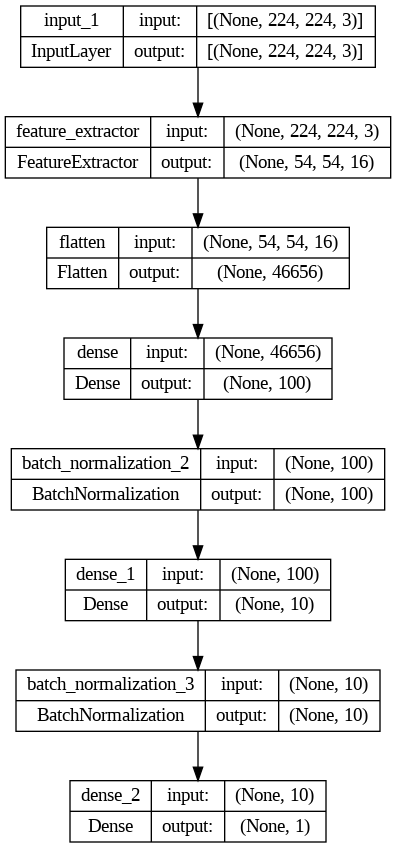

In [29]:
lenet_model_image_path = path_to_drive+"lenet_model_image.png"
plot_model(lenet_model_sub_classed.build_graph(), show_shapes=True, show_layer_names=True, to_file=lenet_model_image_path)

In [30]:
lenet_model_sub_classed.build_graph().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1010

In [31]:
lenet_model_sub_classed.compile(loss=BinaryCrossentropy(),metrics=BinaryAccuracy(),optimizer=Adam(), run_eagerly=False)

In [32]:
lenet_model_sub_classed.fit(train_ds,validation_data=val_ds,epochs=10,verbose=1)

Epoch 1/10
689/689 [==============================] - 26s 18ms/step - loss: 0.4665 - binary_accuracy: 0.7751 - val_loss: 1.1208 - val_binary_accuracy: 0.6842
Epoch 2/10
689/689 [==============================] - 12s 17ms/step - loss: 0.2508 - binary_accuracy: 0.9046 - val_loss: 0.2448 - val_binary_accuracy: 0.9085
Epoch 3/10
689/689 [==============================] - 12s 17ms/step - loss: 0.2196 - binary_accuracy: 0.9194 - val_loss: 0.2063 - val_binary_accuracy: 0.9307
Epoch 4/10
689/689 [==============================] - 13s 17ms/step - loss: 0.2032 - binary_accuracy: 0.9250 - val_loss: 0.2735 - val_binary_accuracy: 0.9209
Epoch 5/10
689/689 [==============================] - 13s 18ms/step - loss: 0.1924 - binary_accuracy: 0.9286 - val_loss: 0.1778 - val_binary_accuracy: 0.9408
Epoch 6/10
689/689 [==============================] - 13s 18ms/step - loss: 0.1804 - binary_accuracy: 0.9368 - val_loss: 0.2028 - val_binary_accuracy: 0.9354
Epoch 7/10
689/689 [==============================] 

In [33]:
lenet_model_sub_classed.evaluate(test_ds)

87/87 [==============================] - 3s 7ms/step - loss: 0.1803 - binary_accuracy: 0.9452


[0.18028362095355988, 0.9452303051948547]

In [34]:
lenet_model_weights_path = path_to_drive+'weights/lenet_model_subclassed_data_aug_weights'

In [35]:
lenet_model_sub_classed.save_weights(lenet_model_weights_path)

In [36]:
lenet_model_sub_classed.load_weights(lenet_model_weights_path)

In [37]:
lenet_model_sub_classed.evaluate(test_ds)

87/87 [==============================] - 3s 6ms/step - loss: 0.1794 - binary_accuracy: 0.9456


[0.17942366003990173, 0.9455930590629578]

# VGG 19

In [38]:
class VGGBlock(Layer):
  def __init__(self,filters,kernel_size,pool_size,number_of_conv_layers,strides,activation,padding):
    super(VGGBlock,self).__init__()
    self.number_of_conv_layers = number_of_conv_layers
    self.conv_layers = [Conv2D(filters=filters,strides=strides,kernel_size=kernel_size,padding=padding,activation=activation) for _ in range(number_of_conv_layers)]
    self.batch_normalization_layers = [BatchNormalization() for _ in range(number_of_conv_layers)]
    self.max_pool = MaxPool2D(pool_size=pool_size,strides=strides*2)

  def call(self,x,training):
    for i in range(self.number_of_conv_layers):
      x = self.conv_layers[i](x)
      x = self.batch_normalization_layers[i](x,training)
    x = self.max_pool(x)
    return x

class VGG19(Model):
  def __init__(self):
    super(VGG19,self).__init__()
    self.vgg_block1 = VGGBlock(filters=64,kernel_size=3,pool_size=2,number_of_conv_layers=2,strides=1,activation='relu',padding='same')
    self.vgg_block2 = VGGBlock(filters=128,kernel_size=3,pool_size=2,number_of_conv_layers=2,strides=1,activation='relu',padding='same')
    self.vgg_block3 = VGGBlock(filters=256,kernel_size=3,pool_size=2,number_of_conv_layers=4,strides=1,activation='relu',padding='same')
    self.vgg_block4 = VGGBlock(filters=512,kernel_size=3,pool_size=2,number_of_conv_layers=4,strides=1,activation='relu',padding='same')
    self.vgg_block5 = VGGBlock(filters=512,kernel_size=3,pool_size=2,number_of_conv_layers=4,strides=1,activation='relu',padding='same')
    self.flatten = Flatten()
    self.dense1 = Dense(4096,activation='relu')
    self.dense2 = Dense(4096,activation='relu')
    self.dense3 = Dense(1000,activation='relu')
    self.output_layer = Dense(1,activation='sigmoid')

  def call(self,x,training=False):
    x = self.vgg_block1(x,training)
    x = self.vgg_block2(x,training)
    x = self.vgg_block3(x,training)
    x = self.vgg_block4(x,training)
    x = self.vgg_block5(x,training)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(x)
    x = self.output_layer(x)
    return x

  def build_graph(self):
        x = Input(shape=(IM_SIZE,IM_SIZE,3))
        return Model(inputs=[x], outputs=self.call(x))

In [39]:
vgg_model = VGG19()
vgg_model.build(input_shape=(1, IM_SIZE, IM_SIZE, 3))

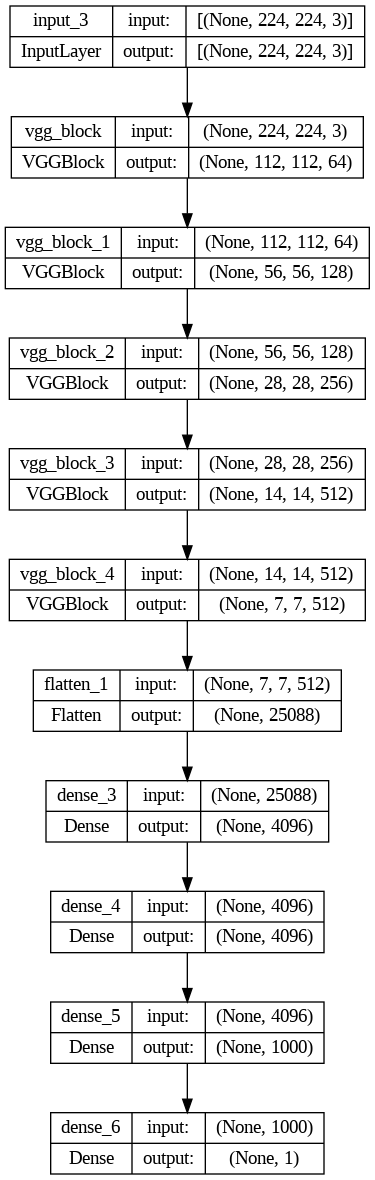

In [40]:
vgg_model_image_path = path_to_drive+"vgg_model_image.png"
plot_model(vgg_model.build_graph(), show_shapes=True, show_layer_names=True, to_file=vgg_model_image_path)

In [41]:
vgg_model.build_graph().summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg_block (VGGBlock)        (None, 112, 112, 64)      39232     
                                                                 
 vgg_block_1 (VGGBlock)      (None, 56, 56, 128)       222464    
                                                                 
 vgg_block_2 (VGGBlock)      (None, 28, 28, 256)       2069504   
                                                                 
 vgg_block_3 (VGGBlock)      (None, 14, 14, 512)       8267776   
                                                                 
 vgg_block_4 (VGGBlock)      (None, 7, 7, 512)         9447424   
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [42]:
vgg_model.compile(loss=BinaryCrossentropy(),metrics=BinaryAccuracy(),optimizer=Adam(), run_eagerly=False)

In [43]:
vgg_model.fit(train_ds,validation_data=val_ds,epochs=5,verbose=1)

Epoch 1/5
689/689 [==============================] - 81s 96ms/step - loss: 1.1994 - binary_accuracy: 0.8294 - val_loss: 0.3773 - val_binary_accuracy: 0.8904
Epoch 2/5
689/689 [==============================] - 63s 90ms/step - loss: 0.1718 - binary_accuracy: 0.9484 - val_loss: 0.1379 - val_binary_accuracy: 0.9575
Epoch 3/5
689/689 [==============================] - 62s 90ms/step - loss: 0.1503 - binary_accuracy: 0.9535 - val_loss: 0.1690 - val_binary_accuracy: 0.9546
Epoch 4/5
689/689 [==============================] - 63s 90ms/step - loss: 0.2101 - binary_accuracy: 0.9386 - val_loss: 0.2551 - val_binary_accuracy: 0.9426
Epoch 5/5
689/689 [==============================] - 62s 90ms/step - loss: 0.2062 - binary_accuracy: 0.9426 - val_loss: 0.1757 - val_binary_accuracy: 0.9328


In [44]:
vgg_model_weights_path = path_to_drive+'vgg_weights/vgg_model_subclassed_data_aug_weights'

In [45]:
vgg_model.save_weights(vgg_model_weights_path)

In [46]:
vgg_model.load_weights(vgg_model_weights_path)

In [47]:
vgg_model.evaluate(test_ds)

In [48]:
class CustomBCE(Loss):
  def __init__(self, FACTOR=1):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

In [50]:
vgg_model_2 = VGG19()
vgg_model_weights_path2 = path_to_drive+'vgg_weights2/vgg_model_subclassed_data_aug_weights'
vgg_model_2.compile(loss=CustomBCE(),metrics=BinaryAccuracy(),optimizer=Adam(), run_eagerly=False)

In [51]:
vgg_model_2.metrics_names

[]

# Custom Training, Validation, Testing Loops

In [52]:
# @tf.function
def train_process(model, ds, optimizer, train_loss, train_metric):
    losses = []
    train_metric.reset_states()

    with tqdm(total=len(ds), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') as pbar:
        for batch, (x_batch, y_batch) in enumerate(ds):
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss_value = train_loss(y_batch, logits)
                losses.append(loss_value)

            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            train_metric.update_state(y_batch, logits)
            pbar.set_description(f"Training loss for step {batch}: {loss_value:.4f}")
            pbar.update()

    train_acc = train_metric.result()
    return losses, train_acc

# @tf.function
def val_process(model, ds, val_loss, val_metric):
    losses = []
    val_metric.reset_states()

    with tqdm(total=len(ds), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') as pbar:
        for batch, (x_batch, y_batch) in enumerate(ds):
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=False)
                loss_value = val_loss(y_batch, logits)
                losses.append(loss_value)

            val_metric.update_state(y_batch, logits)
            pbar.set_description(f"Validation loss for step {batch}: {loss_value:.4f}")
            pbar.update()

    val_acc = val_metric.result()
    return losses, val_acc

In [53]:
epochs = 5
train_metric = BinaryAccuracy()
train_loss = CustomBCE()
optimizer = Adam()
val_metric = BinaryAccuracy()
val_loss = CustomBCE()
def train_model(model,train_ds,val_ds,optimizer,train_loss,train_metric,val_loss,_val_metric):
  mean_train_losses = []
  train_accuracies = []
  mean_val_losses = []
  val_accuracies = []

  for epoch in range(epochs):
    start_time = time.time()
    train_losses, train_acc = train_process(model,train_ds,optimizer,train_loss,train_metric)
    val_losses, val_acc = val_process(model,val_ds,val_loss,_val_metric)

    mean_loss_train = np.mean(train_losses)
    mean_train_losses.append(mean_loss_train)

    mean_loss_val = np.mean(val_losses)
    mean_val_losses.append(mean_loss_val)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'epoch {epoch}: train loss={mean_loss_train}, train acc={train_acc}, val loss={mean_loss_val}, val acc={val_acc}')
    print("Time taken: %.2fs" % (time.time() - start_time))

  return mean_train_losses,train_accuracies,mean_val_losses,val_accuracies

In [54]:
lenet_model_2 = LeNetModel()
# lenet_model_2.compile(loss=BinaryCrossentropy(),optimizer=Adam(), run_eagerly=False)
mean_train_losses,train_accuracies,mean_val_losses,val_accuracies=train_model(lenet_model_2,train_ds,val_ds,optimizer,train_loss,train_metric,val_loss,val_metric)

  0%|          | 0/689 WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f79e0e31d80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Training loss for step 688: 0.2461: 100%|██████████| 689/689 
Validation loss for step 86: 0.0775: 100%|██████████| 87/87 


epoch 0: train loss=0.338798850774765, train acc=0.8599292635917664, val loss=0.24779826402664185, val acc=0.911433756351471
Time taken: 50.23s


Training loss for step 688: 0.0995: 100%|██████████| 689/689 
Validation loss for step 86: 0.0516: 100%|██████████| 87/87 


epoch 1: train loss=0.2162175327539444, train acc=0.9226617217063904, val loss=0.22746863961219788, val acc=0.9201452136039734
Time taken: 45.63s


Training loss for step 688: 0.3926: 100%|██████████| 689/689 
Validation loss for step 86: 0.0030: 100%|██████████| 87/87 


epoch 2: train loss=0.20144590735435486, train acc=0.9291481375694275, val loss=0.18239858746528625, val acc=0.9397459030151367
Time taken: 44.74s


Training loss for step 688: 0.0521: 100%|██████████| 689/689 
Validation loss for step 86: 0.0815: 100%|██████████| 87/87 


epoch 3: train loss=0.184000164270401, train acc=0.9360882043838501, val loss=0.1587049663066864, val acc=0.9466424584388733
Time taken: 44.79s


Training loss for step 688: 0.0233: 100%|██████████| 689/689 
Validation loss for step 86: 0.0494: 100%|██████████| 87/87 

epoch 4: train loss=0.17040985822677612, train acc=0.9451600909233093, val loss=0.15492887794971466, val acc=0.9470054507255554
Time taken: 44.87s


In [55]:
test_metric = BinaryAccuracy()
test_loss = CustomBCE()
def test_process(model, ds, test_loss, test_metric):
    losses = []
    test_metric.reset_states()

    with tqdm(total=len(ds), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') as pbar:
        for batch, (x_batch, y_batch) in enumerate(ds):
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=False)
                loss_value = test_loss(y_batch, logits)
                losses.append(loss_value)

            test_metric.update_state(y_batch, logits)
            pbar.set_description(f"Test loss for step {batch}: {loss_value:.4f}")
            pbar.update()

    test_acc = test_metric.result()
    mean_test_loss = np.mean(losses)
    return mean_test_loss,losses, test_acc

In [57]:
mean_test_loss,test_losses, test_acc=test_process(lenet_model_2,test_ds,test_loss,test_metric)

Test loss for step 86: 0.0407: 100%|██████████| 87/87 


In [72]:
def plot_loss_accuracy_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')

  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')

  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [59]:
print(mean_train_losses)

[0.33879885, 0.21621753, 0.2014459, 0.18400016, 0.17040986]


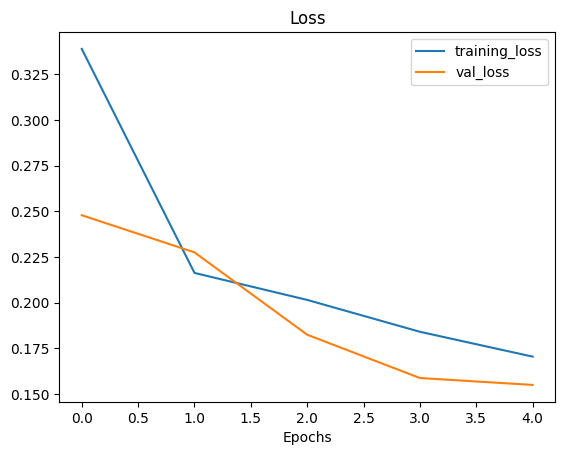

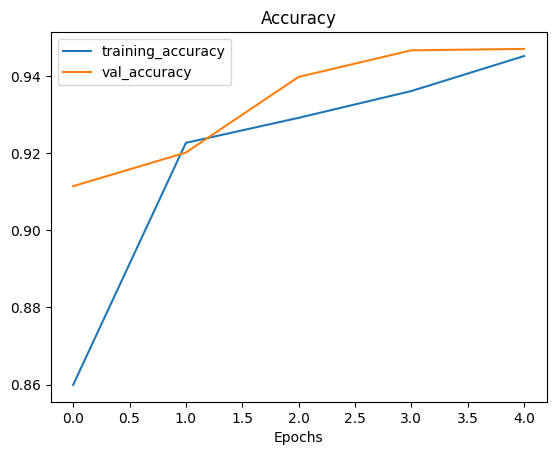

In [81]:
history = {
      'loss': mean_train_losses,
      'accuracy':train_accuracies,
      'val_loss':mean_val_losses,
      'val_accuracy': val_accuracies,
}
history_callback = History()
history_callback.history=history

plot_loss_accuracy_curves(history_callback)

# Transfer Learning

In [62]:
def create_model(model_url,name,num_classes=1):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(IM_SIZE,IM_SIZE)+(3,)) # define the input image shape

  activation = 'sigmoid' if num_classes==1 else 'softmax'
  # Create our own model

  # Sequential API
  # model = tf.keras.Sequential([
  #   feature_extractor_layer, # use the feature extraction layer as the base
  #   Dense(num_classes, activation=activation, name='output_layer') # create our own output layer
  # ])

  # Functional API
  input = Input(shape=(IM_SIZE,IM_SIZE,3), name='input_layer')
  x = feature_extractor_layer(input)
  output = Dense(num_classes, activation=activation, name='output_layer')(x)
  model = Model(input,output,name = name)


  return model

In [63]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
            BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

efficientNet_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'

efficientNet_model = create_model(efficientNet_url,'efficient_net')

In [64]:
efficientNet_model.summary()

Model: "efficient_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extraction_layer (K  (None, 1280)             5919312   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 1,281
Non-trainable params: 5,919,312
_________________________________________________________________


In [65]:
efficientNet_model.compile(loss=BinaryCrossentropy(),
                           optimizer=Adam(),
                           metrics=metrics)

In [66]:
checkpoint_filepath = path_to_drive+'model_checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger_filename = path_to_drive+'csv_logger'
csv_logger_callback = CSVLogger(
    csv_logger_filename, separator=',', append=False
)

In [68]:
callbacks = [model_checkpoint_callback,csv_logger_callback]
efficientnet_history = efficientNet_model.fit(train_ds,
                                              epochs=10,
                                              steps_per_epoch=len(train_ds),
                                              validation_data=val_ds,
                                              validation_steps=len(val_ds),
                                              callbacks=callbacks)

Epoch 1/10
689/689 [==============================] - 14s 20ms/step - loss: 0.1606 - tp: 10634.0000 - fp: 872.0000 - tn: 10149.0000 - fn: 391.0000 - accuracy: 0.9427 - precision: 0.9242 - recall: 0.9645 - auc: 0.9836 - val_loss: 0.1555 - val_tp: 1340.0000 - val_fp: 98.0000 - val_tn: 1265.0000 - val_fn: 52.0000 - val_accuracy: 0.9456 - val_precision: 0.9318 - val_recall: 0.9626 - val_auc: 0.9845
Epoch 2/10
689/689 [==============================] - 14s 19ms/step - loss: 0.1563 - tp: 10634.0000 - fp: 847.0000 - tn: 10176.0000 - fn: 389.0000 - accuracy: 0.9439 - precision: 0.9262 - recall: 0.9647 - auc: 0.9841 - val_loss: 0.1516 - val_tp: 1359.0000 - val_fp: 112.0000 - val_tn: 1251.0000 - val_fn: 33.0000 - val_accuracy: 0.9474 - val_precision: 0.9239 - val_recall: 0.9763 - val_auc: 0.9856
Epoch 3/10
689/689 [==============================] - 14s 20ms/step - loss: 0.1502 - tp: 10664.0000 - fp: 846.0000 - tn: 10177.0000 - fn: 359.0000 - accuracy: 0.9453 - precision: 0.9265 - recall: 0.9674 

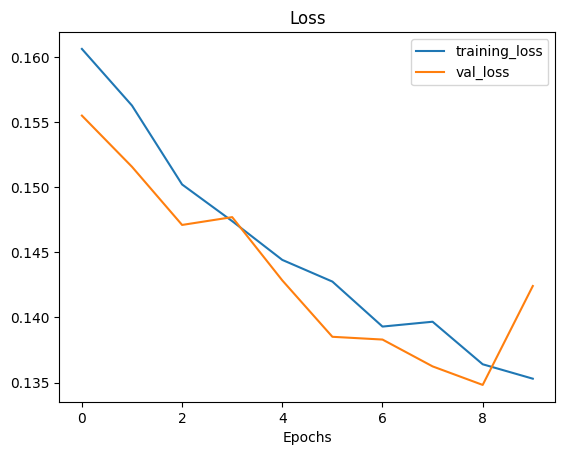

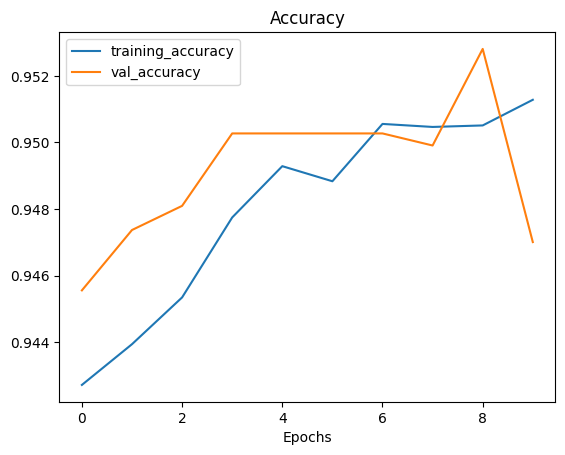

In [82]:
plot_loss_accuracy_curves(efficientnet_history)

In [86]:
efficientNet_model.evaluate(test_ds)

87/87 [==============================] - 4s 14ms/step - loss: 0.1525 - tp: 1289.0000 - fp: 63.0000 - tn: 1327.0000 - fn: 78.0000 - accuracy: 0.9489 - precision: 0.9534 - recall: 0.9429 - auc: 0.9874


[0.1524989902973175,
 1289.0,
 63.0,
 1327.0,
 78.0,
 0.9488574266433716,
 0.9534023404121399,
 0.9429407715797424,
 0.9874276518821716]

In [84]:
efficientnet_v2_b3_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    classes=1,
    classifier_activation='sigmoid',
    include_preprocessing=True
)

In [87]:
efficientnet_v2_b3_model.trainable = False

inputs = tf.keras.layers.Input(shape=(IM_SIZE, IM_SIZE, 3), name="input_layer")

x = efficientnet_v2_b3_model(inputs)
print(f"Shape after base_model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=CustomBCE(),
              optimizer=Adam(),
              metrics=metrics)

efficientnet_v2_b3_model_history = model_0.fit(train_ds,
                                 epochs=5,
                                 steps_per_epoch=len(train_ds),
                                 validation_data=val_ds,
                                 validation_steps=len(val_ds),
                                 callbacks=callbacks)

Shape after base_model: (None, 7, 7, 1536)
After GlobalAveragePooling2D(): (None, 1536)
Epoch 1/5
689/689 [==============================] - 35s 31ms/step - loss: 0.6967 - tp: 6930.0000 - fp: 5767.0000 - tn: 6646.0000 - fn: 5460.0000 - accuracy: 0.5474 - precision: 0.5458 - recall: 0.5593 - auc: 0.5927 - val_loss: 0.6978 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1363.0000 - val_fn: 1392.0000 - val_accuracy: 0.4947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5578
Epoch 2/5
689/689 [==============================] - 18s 26ms/step - loss: 0.6970 - tp: 5536.0000 - fp: 5528.0000 - tn: 5495.0000 - fn: 5487.0000 - accuracy: 0.5004 - precision: 0.5004 - recall: 0.5022 - auc: 0.5008 - val_loss: 0.7020 - val_tp: 1396.0000 - val_fp: 1359.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5067 - val_precision: 0.5067 - val_recall: 1.0000 - val_auc: 0.6438
Epoch 3/5
689/689 [==============================] - 18s 26ms/step - loss: 0.6962 - tp: 5782.0000 

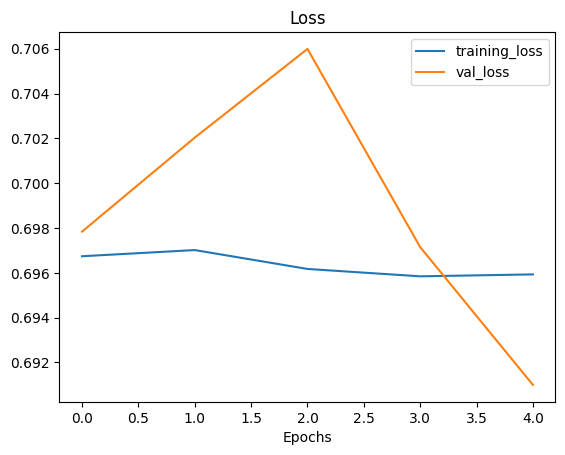

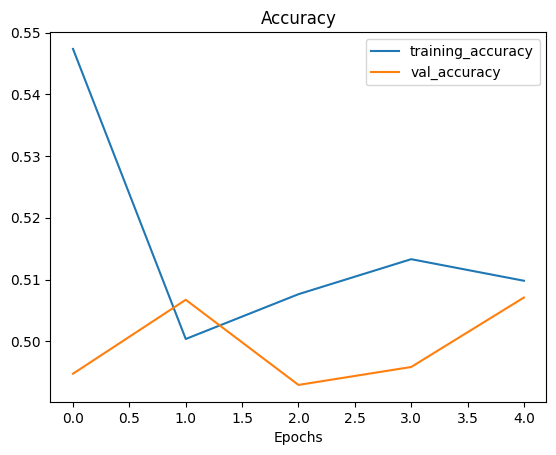

In [88]:
plot_loss_accuracy_curves(efficientnet_v2_b3_model_history)

In [89]:
for layer_number, layer in enumerate(efficientnet_v2_b3_model.layers):
  print(layer_number, layer.name)

0 input_6
1 rescaling_1
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 bloc

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.823871 to fit



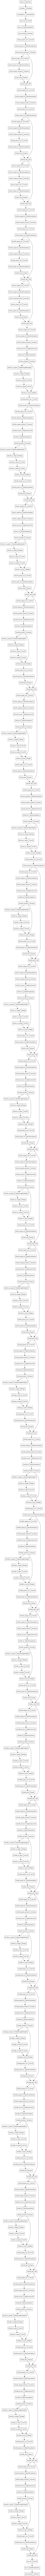

In [90]:
plot_model(efficientnet_v2_b3_model)

###Try out Data Augmentation with Efficinet Net V2 B3

In [92]:
efficientnet_v2_b3_model_1=tf.keras.applications.efficientnet_v2.EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    classes=1,
    classifier_activation='sigmoid',
    include_preprocessing=True
)

efficientnet_v2_b3_model_1.trainable = False

inputs = tf.keras.layers.Input(shape=(IM_SIZE, IM_SIZE, 3), name="input_layer")

x = DataAugmentation()(inputs)

x = efficientnet_v2_b3_model_1(inputs)
print(f"Shape after base_model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=CustomBCE(),
              optimizer=Adam(),
              metrics=metrics)

efficientnet_v2_b3_model_1_history = model_1.fit(train_ds,
                                 epochs=5,
                                 steps_per_epoch=len(train_ds),
                                 validation_data=val_ds,
                                 validation_steps=len(val_ds),
                                 callbacks=callbacks)

Shape after base_model: (None, 7, 7, 1536)
After GlobalAveragePooling2D(): (None, 1536)
Epoch 1/5
689/689 [==============================] - 33s 30ms/step - loss: 0.6971 - tp: 6685.0000 - fp: 6631.0000 - tn: 5753.0000 - fn: 5732.0000 - accuracy: 0.5015 - precision: 0.5020 - recall: 0.5384 - auc: 0.5031 - val_loss: 0.6924 - val_tp: 1395.0000 - val_fp: 1360.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5064 - val_precision: 0.5064 - val_recall: 1.0000 - val_auc: 0.5450
Epoch 2/5
689/689 [==============================] - 19s 26ms/step - loss: 0.6969 - tp: 5967.0000 - fp: 5828.0000 - tn: 5195.0000 - fn: 5056.0000 - accuracy: 0.5063 - precision: 0.5059 - recall: 0.5413 - auc: 0.5095 - val_loss: 0.6978 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1359.0000 - val_fn: 1396.0000 - val_accuracy: 0.4933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6466
Epoch 3/5
689/689 [==============================] - 19s 26ms/step - loss: 0.6975 - tp: 5408.0000 

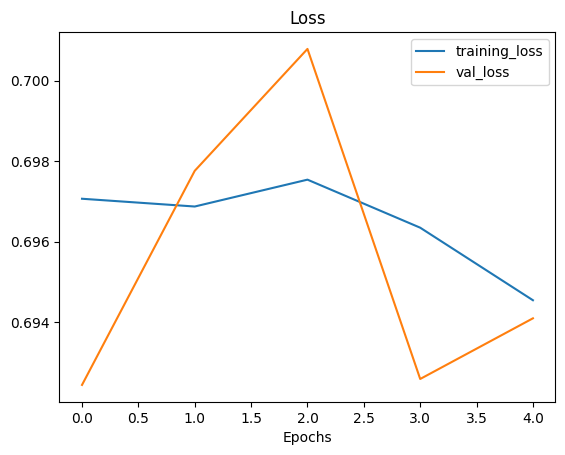

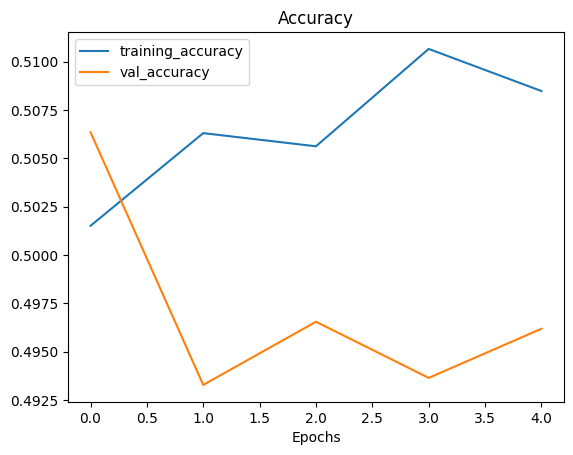

In [93]:
plot_loss_accuracy_curves(efficientnet_v2_b3_model_1_history)

In [94]:
for layer_number, layer in enumerate(efficientnet_v2_b3_model_1.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_9 | Layer type: <keras.engine.input_layer.InputLayer object at 0x7f78396e3970> | Trainable? False
Layer number: 1 | Layer name: rescaling_4 | Layer type: <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f7839fedcf0> | Trainable? False
Layer number: 2 | Layer name: normalization_4 | Layer type: <keras.layers.preprocessing.normalization.Normalization object at 0x7f78396e25c0> | Trainable? False
Layer number: 3 | Layer name: stem_conv | Layer type: <keras.layers.convolutional.conv2d.Conv2D object at 0x7f78506a4a00> | Trainable? False
Layer number: 4 | Layer name: stem_bn | Layer type: <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7839f195d0> | Trainable? False
Layer number: 5 | Layer name: stem_activation | Layer type: <keras.layers.core.activation.Activation object at 0x7f7839f68220> | Trainable? False
Layer number: 6 | Layer name: block1a_project_conv | Layer type: <keras.layers.convolutional.co

In [96]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1536)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1537      
                                                                 
Total params: 12,932,159
Trainable params: 1,537
Non-trainable params: 12,930,622
_________________________________________________________________


### Fine Tuning Efficient net V2 B3

In [97]:
efficientnet_v2_b3_model_1.trainable = True

for layer in efficientnet_v2_b3_model_1.layers[:-10]:
  layer.trainable = False

model_1.compile(loss=CustomBCE(),
                optimizer=Adam(learning_rate=0.0001),
                metrics=metrics)

In [98]:
for layer_number, layer in enumerate(efficientnet_v2_b3_model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_4 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
3

In [99]:
print(len(model_1.trainable_variables))

12


In [106]:
fine_tune_epochs = 20

efficientnet_v2_b3_model_1_history_2 = model_1.fit(train_ds,
                                               epochs=fine_tune_epochs,
                                               validation_data=val_ds,
                                               initial_epoch=efficientnet_v2_b3_model_1_history.epoch[-1],
                                               validation_steps=len(val_ds),
                                               callbacks=callbacks)

Epoch 5/20
689/689 [==============================] - 20s 28ms/step - loss: 0.6888 - tp: 5985.0000 - fp: 5138.0000 - tn: 5885.0000 - fn: 5038.0000 - accuracy: 0.5384 - precision: 0.5381 - recall: 0.5430 - auc: 0.5541 - val_loss: 0.6911 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1368.0000 - val_fn: 1387.0000 - val_accuracy: 0.4966 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6768
Epoch 6/20
689/689 [==============================] - 20s 28ms/step - loss: 0.6867 - tp: 6054.0000 - fp: 5085.0000 - tn: 5938.0000 - fn: 4969.0000 - accuracy: 0.5440 - precision: 0.5435 - recall: 0.5492 - auc: 0.5651 - val_loss: 0.6906 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 1356.0000 - val_fn: 1396.0000 - val_accuracy: 0.4926 - val_precision: 0.3333 - val_recall: 7.1582e-04 - val_auc: 0.6711
Epoch 7/20
689/689 [==============================] - 20s 28ms/step - loss: 0.6866 - tp: 5907.0000 - fp: 4945.0000 - tn: 6076.0000 - fn: 5118.0000 - accuracy: 0.5435 - precision: 0.5443 - 

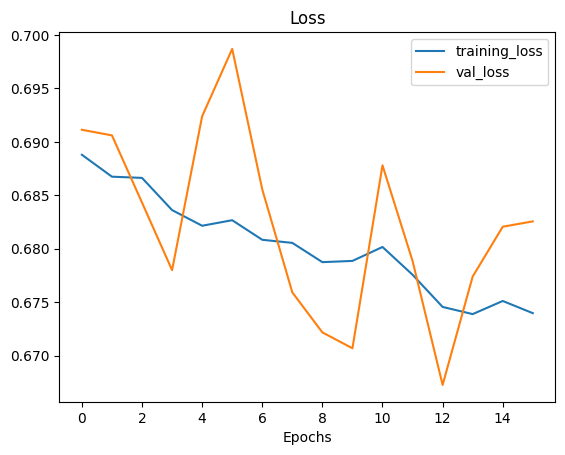

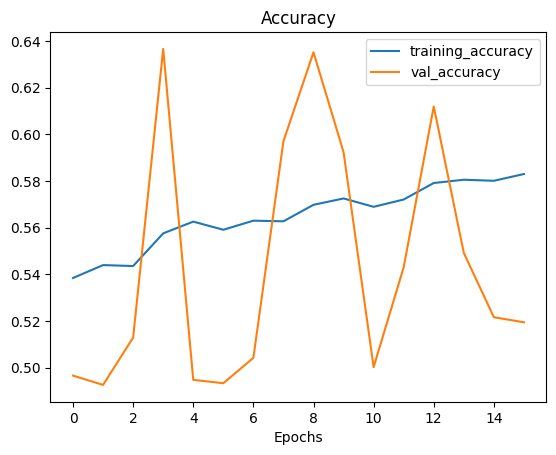

In [107]:
plot_loss_accuracy_curves(efficientnet_v2_b3_model_1_history_2)

In [108]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
21
[0.5015120506286621, 0.5063049793243408, 0.5056245923042297, 0.5106595158576965, 0.5084822773933411, 0.5384196639060974, 0.543953537940979, 0.5435453057289124, 0.557561457157135, 0.5625963807106018, 0.5591036677360535, 0.5630046129226685, 0.562732458114624, 0.5698086023330688, 0.5725301504135132, 0.5689467191696167, 0.5720765590667725, 0.5791527032852173, 0.5805588364601135, 0.5801052451133728, 0.5830082297325134]


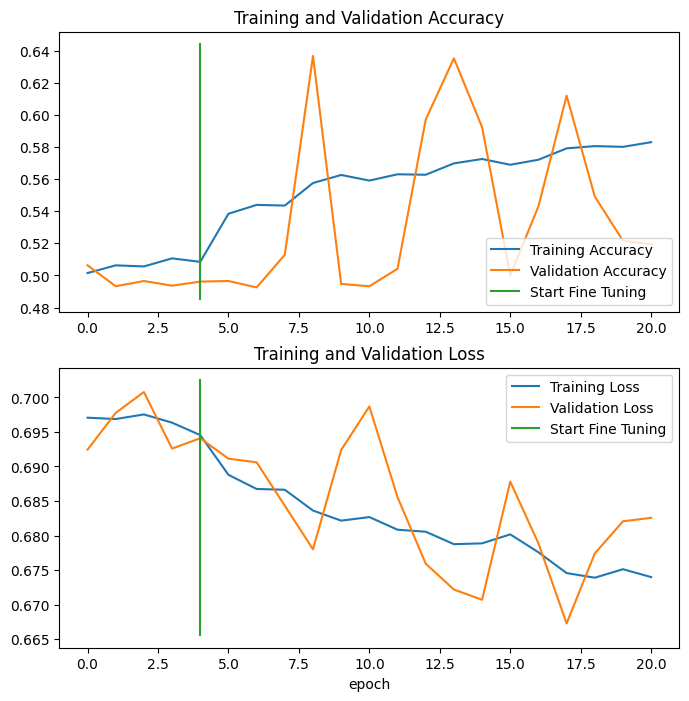

In [109]:
compare_historys(original_history=efficientnet_v2_b3_model_1_history,
                 new_history=efficientnet_v2_b3_model_1_history_2,
                 initial_epochs=5)


In [110]:
model_1.evaluate(test_ds)

87/87 [==============================] - 4s 20ms/step - loss: 0.6796 - tp: 82.0000 - fp: 14.0000 - tn: 1379.0000 - fn: 1282.0000 - accuracy: 0.5299 - precision: 0.8542 - recall: 0.0601 - auc: 0.6866


[0.6795746684074402,
 82.0,
 14.0,
 1379.0,
 1282.0,
 0.5299238562583923,
 0.8541666865348816,
 0.06011730059981346,
 0.6865972280502319]

In [114]:
path_of_efficient_net_fine_tune_model = path_to_drive+'efficient_net_fine_tune/efficient_net_fine_tune'

In [113]:
model_1.save_weights(path_of_efficient_net_fine_tune_model)

In [115]:
model_1.load_weights(path_of_efficient_net_fine_tune_model)

In [116]:
model_1.evaluate(test_ds)

87/87 [==============================] - 4s 21ms/step - loss: 0.6797 - tp: 81.0000 - fp: 14.0000 - tn: 1379.0000 - fn: 1283.0000 - accuracy: 0.5296 - precision: 0.8526 - recall: 0.0594 - auc: 0.6864


[0.6796566247940063,
 81.0,
 14.0,
 1379.0,
 1283.0,
 0.5295611023902893,
 0.8526315689086914,
 0.05938416346907616,
 0.6863886117935181]

# Evaluating the predictions of previous models

In [117]:
pred_probs = model_1.predict(test_ds)

87/87 [==============================] - 6s 16ms/step


In [118]:
print(pred_probs.shape)

(2757, 1)


In [126]:
pred_probs[:10]

array([[0.4521326 ],
       [0.31415388],
       [0.44807684],
       [0.31117904],
       [0.42788193],
       [0.40067434],
       [0.40120056],
       [0.35393077],
       [0.46451265],
       [0.35983017]], dtype=float32)

In [123]:
y_labels = []
for image, label in test_ds.unbatch():
  # label=info.features['label'].int2str(label)
  y_labels.append(label.numpy())
y_labels[:10]

[1, 1, 0, 0, 0, 1, 0, 1, 1, 0]

In [129]:
y_pred = pred_probs>0.5
y_pred[:10]

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

### Confusion Matrix

In [139]:
def make_confusion_matrix(y_true,y_pred,threshold=0.5):
  cm = confusion_matrix(y_true, y_pred > threshold)

  plt.figure(figsize=(8,8))

  sns.heatmap(cm, annot=True,)
  plt.title('Confusion matrix - {}'.format(threshold))
  plt.ylabel('Actual')
  plt.xlabel('Predicted')

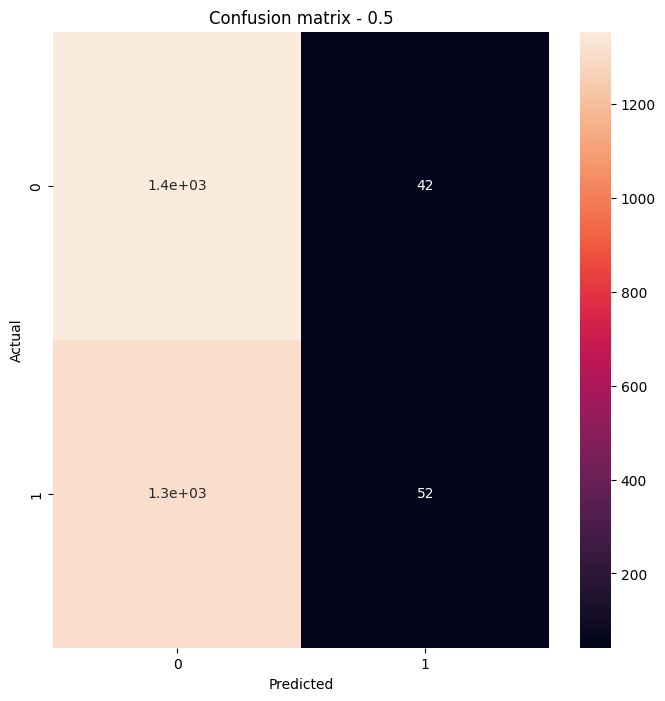

In [136]:
make_confusion_matrix(y_labels,y_pred)

In [137]:
lenet_model_preds = lenet_model_sub_classed.predict(test_ds)

87/87 [==============================] - 3s 6ms/step


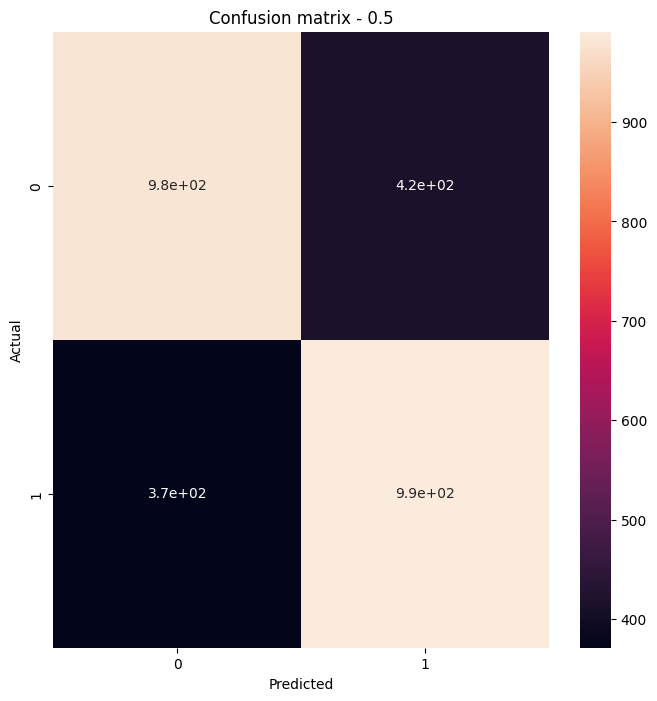

In [138]:
make_confusion_matrix(y_labels,lenet_model_preds)

In [140]:
vgg_model_pred = vgg_model.predict(test_ds)

87/87 [==============================] - 5s 29ms/step


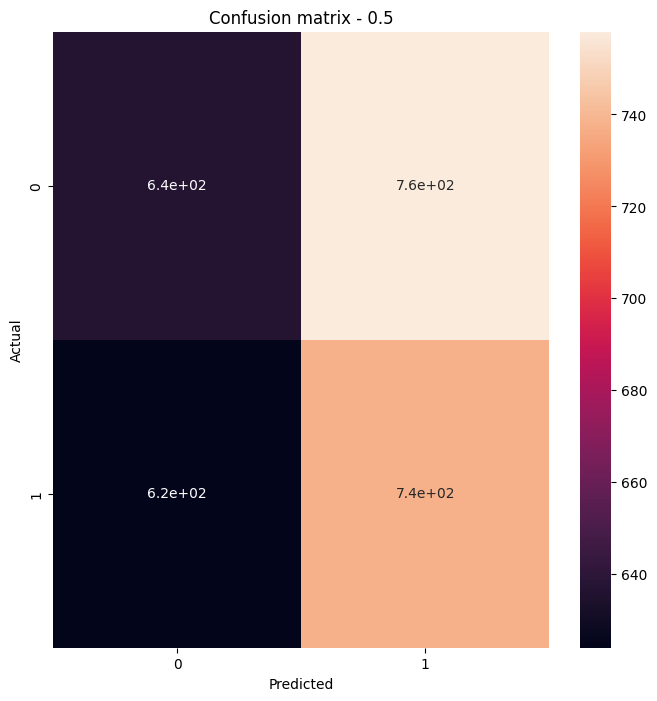

In [141]:
make_confusion_matrix(y_labels,vgg_model_pred)

### ROC Plots

In [158]:
def roc_plot(labels,predicted):
  fp, tp, thresholds = roc_curve(labels, predicted)
  plt.plot(fp, tp)
  plt.xlabel("False Positive rate")
  plt.ylabel("True Positive rate")

  plt.grid()

  skip = 40

  for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])

  plt.show()

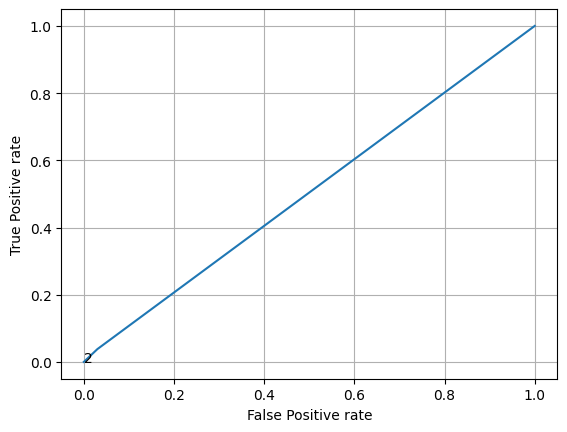

In [159]:
roc_plot(y_labels,y_pred)

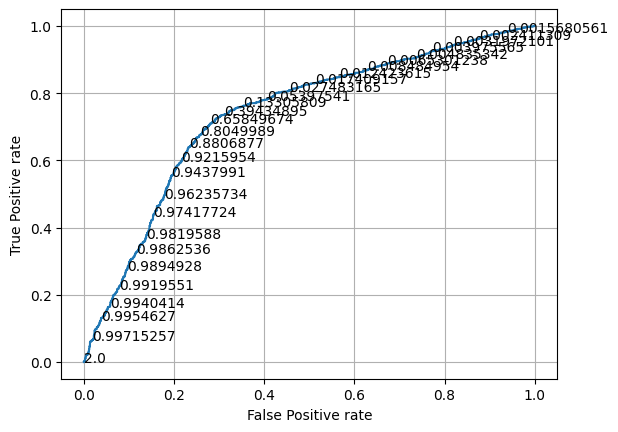

In [160]:
roc_plot(y_labels,lenet_model_preds)

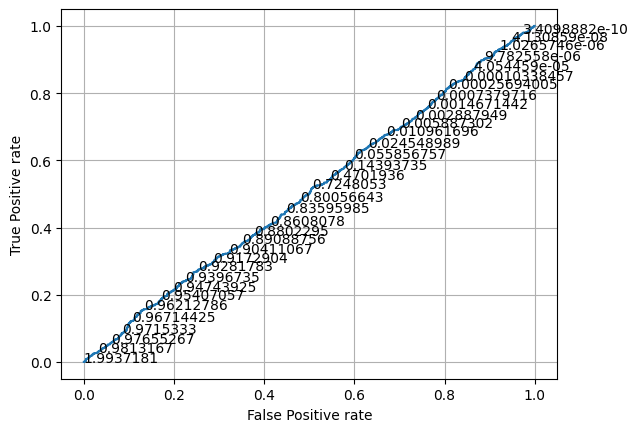

In [161]:
roc_plot(y_labels,vgg_model_pred)

### Classification Report

In [154]:
print(classification_report(y_labels, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.97      0.67      1395
           1       0.55      0.04      0.07      1362

    accuracy                           0.51      2757
   macro avg       0.53      0.50      0.37      2757
weighted avg       0.53      0.51      0.37      2757



In [156]:
print(classification_report(y_labels, lenet_model_preds>0.5))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71      1395
           1       0.70      0.73      0.72      1362

    accuracy                           0.71      2757
   macro avg       0.71      0.71      0.71      2757
weighted avg       0.71      0.71      0.71      2757



In [157]:
print(classification_report(y_labels, vgg_model_pred>0.5))

              precision    recall  f1-score   support

           0       0.51      0.46      0.48      1395
           1       0.49      0.54      0.52      1362

    accuracy                           0.50      2757
   macro avg       0.50      0.50      0.50      2757
weighted avg       0.50      0.50      0.50      2757

